# 人臉辨識 - 轉換、對齊、裁剪、特徵擷取與比對

人臉辨識大致可分成四個主要的步驟:
1. 人臉偵測
2. 人臉轉換、對齊與裁剪
3. 人臉特徵擷取
4. 人臉特徵比對

這個Jupyter Notebook展示了一個四個步驟整合起來的結果。但要進行這個Jupyter notebook之前, 要先完成以下兩個程序：

* [[01-face-detect-align-and-crop](https://github.com/erhwenkuo/face-recognition/blob/master/01-face-detect-align-and-crop.ipynb)] - 介紹如何進行"人臉偵測"、"對齊" & "裁剪"。


* [[02-face-embedding-and-recognition-classifier](https://github.com/erhwenkuo/face-recognition/blob/master/02-face-embedding-and-recognition-classifier.ipynb)] - 介紹如何進行人臉特徵擷取(FaceNet) & 訓練人臉分類器。


![face-recognition](http://devfun-lab.com/en/wdvfnp/wp-content/uploads/2017/09/h3.jpg)

## face-recognition 專案說明

[face-recognition](https://github.com/erhwenkuo/face-recognition)包含了使用MTCNN、FaceNet以及SVM(Suport Vector Machine)三種演算法來進行人臉辨識的整個循環。

### 安裝

```bash
git clone https://github.com/erhwenkuo/face-recognition.git
cd face-recognition
...
```

### 資料集說明

LFW資料集是一個常見的人臉資料集，歷史非常悠久。LFW資料集中收錄了5749位公眾人物的人臉影像，總共有超過一萬三千多張影像檔案。但大部份公眾人物的影像都只有一張，只有1680位有超過一張照片，而極少數有超過10張照片。

資料集的網站: http://vis-www.cs.umass.edu/lfw

### 專案的檔案路徑佈局

1. 使用Git從[erhwenkuo/face-recognition](https://github.com/erhwenkuo/face-recognition.git)下載整個專案源碼
2. 在`face-recognition`的目錄裡產生二個子目錄`data`與`model`
3. 從[Labeled Faces in the Wild資料集官網]點撃[All images as gzipped tar file](http://vis-www.cs.umass.edu/lfw/lfw.tgz)來下載`lfw.tgz`。
4. 解壓縮`lfw.tgz`到`face-recognition/data/`的目錄下
5. 執行`01-face-detect-align-and-crop.ipynb`來進行臉部偵測、對齊 & 裁剪
6. 下載Facenet模型檔[20170511-185253.zip(168M)](https://drive.google.com/file/d/0B5MzpY9kBtDVZ2RpVDYwWmxoSUk)並解壓縮到"model/facenet"的目錄下。
7. 在"model"的目錄下產生一個子目錄"svm"來存放"人臉分類器"的模型。
8. 執行`02-face-embedding-and-recognition-classifier.ipynb`來進行人臉特徵擷取(FaceNet) & 訓練人臉分類器
9. 在"data"的目錄下產生一個子目錄"test"來存放"人臉辨識"用的測試圖像


最後你的目錄結構看起來像這樣: (這裡只列出來在這個範例會用到的相關檔案與目錄)
```
face-recognition/
├── 01-face-detect-align-and-crop.ipynb
├── 02-face-embedding-and-recognition-classifier.ipynb
├── 03-face-classification.ipynb
├── detect_face.py
├── facenet.py
├── visualization_utils.py
├── model/
│   ├── svm/                                <--- 人臉分類器(svm)的模型
│   │   └── lfw_svm_classifier.pkl
│   ├── mtcnn/
│   │   ├── det1.npy
│   │   ├── det2.npy
│   │   └── det3.npy
│   └── facenet/                            <--- Facenet的模型
│       └── 20170512-110547/
│          ├── 20170512-110547.pb
│          ├── model-20170512-110547.ckpt-250000.data-00000-of-00001
│          ├── model-20170512-110547.ckpt-250000.index
│          └── model-20170512-110547.meta
└── data/
    ├── test/
    ├── lfw/
    │   ├── Aaron_Eckhart/     
    │   │   └── Aaron_Eckhart_0001.jpg
    │   ├── ...
    │   └── Zydrunas_Ilgauskas/
    │       └── Zydrunas_Ilgauskas_0001.jpg
    └── lfw_crops/                          <--- 經過偵測、對齊 & 裁剪後的人臉圖像
        ├── Aaron_Eckhart/     
        │   └── Aaron_Eckhart_0001.png
        ├── ...
        └── Zydrunas_Ilgauskas/
            └── Zydrunas_Ilgauskas_0001.png    
```

### STEP 1. 載入相關函式庫

In [1]:
# 屏蔽Jupyter的warning訊息
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
import os

os.environ['CUDA_VISIBLE_DEVICES']='2, 3'
from os.path import join as pjoin
import sys
import time
import copy
import random
import math
from tqdm import tqdm
from scipy import misc
from scipy.spatial import distance # 用來計算歐幾里德距離 (euclidean)

# 圖像處理相關函式庫
import cv2
import matplotlib.pyplot as plt

# 多維向量處理相關函式庫
import numpy as np

# 深度學習相關函式庫
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# 機械學習
from sklearn.svm import LinearSVC
import joblib

# 模型序列化函式庫
import pickle

# 專案相關函式庫
import facenet
import detect_face
import visualization_utils as vis_utils

Instructions for updating:
non-resource variables are not supported in the long term


### STEP 2. 設定相關設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 模型的資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# MTCNN的模型
MTCNN_MODEL_PATH = os.path.join(MODEL_PATH, "mtcnn")

# FaceNet的模型
FACENET_MODEL_PATH = os.path.join(MODEL_PATH, "facenet","20170512-110547","20170512-110547.pb")

# Classifier的模型
SVM_MODEL_PATH = os.path.join(MODEL_PATH, "svm", "lfw_svm_classifier.pkl")

# 訓練/驗證用的圖像資料目錄
IMG_IN_PATH = os.path.join(DATA_PATH, "pic")

# 訓練/驗證用的圖像資料目錄
IMG_OUT_PATH = os.path.join(DATA_PATH, "pic_crops")

### STEP 3. 載入人臉Facenet處理過的相關的人臉embedding資料

轉換每張人臉的圖像成為Facenet的人臉特徵向量(128 bytes)表示。

函式: `facenet.get_dataset`
```
參數:
    paths (string): 圖像資料集的檔案路徑
    has_class_directories (bool): 是否使用子目錄名作為人臉的identity (預設為True)
    path_expanduser (bool): 是否把path中包含的"~"和"~user"轉換成在作業系統下的用戶根目錄 (預設為False)
回傳:
    dataset (list[ImageClass])： 人臉類別(ImageClass)的列表與圖像路徑
```

In [3]:
# 反序列化相關可重覆使用的資料
# "人臉embedding"的資料
with open(os.path.join(DATA_PATH,'lfw_emb_features.pkl'), 'rb') as emb_features_file:
    emb_features =pickle.load(emb_features_file)

# "人臉embedding"所對應的標籤(label)的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels.pkl'), 'rb') as emb_lables_file:
    emb_labels =pickle.load(emb_lables_file)

# "標籤(label)對應到人臉名稱的字典的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels_dict.pkl'), 'rb') as emb_lables_dict_file:
    emb_labels_dict =pickle.load(emb_lables_dict_file)

由於lfw的人臉資料庫的人臉圖像太少, 因此經過過濾之後我們從lfw的人臉資料庫中選出423個人臉的類別(每個類別都至少有5張的圖像以上)來做為人臉辨識的目標範例資料集。

In [4]:
emb_dict = {} # key 是label, value是embedding list
for feature,label in zip(emb_features, emb_labels):
    # 檢查key有沒有存在
    if label in emb_dict:
        emb_dict[label].append(feature)
    else:
        emb_dict[label] = [feature]

In [5]:
# 計算兩個人臉特徵（Facenet Embedding 128 bytes vector)的歐式距離
def calc_dist(face1_emb, face2_emb):    
    return distance.euclidean(face1_emb, face2_emb)

face_distance_threshold = 1.1

# 計算一個人臉的embedding是不是歸屬某一個人
# 根據Google Facenet的論文, 透過計算兩個人臉embedding的歐氏距離
# 0: 代表為同一個人臉 , threshold <1.1 代表兩個人臉非常相似 
def is_same_person(face_emb, face_label, threshold=1.1):
    emb_distances = []
    emb_features = emb_dict[face_label]
    for i in range(len(emb_features)):
        emb_distances.append(calc_dist(face_emb, emb_features[i]))
    
    # 取得平均值
    if np.mean(emb_distances) > threshold: # threshold <1.1 代表兩個人臉非常相似 
        return False
    else:
        return True

### STEP 4. 載入預訓練MTCNN的模型來偵測人臉位置

#### 設定人臉偵測模型所需的相關參數

In [6]:
minsize = 40  # 最小的臉部的大小
threshold = [0.6, 0.7, 0.7]  # 三個網絡(P-Net, R-Net, O-Net)的閥值
factor = 0.709  # scale factor

margin = 44 # 在裁剪人臉時的邊框margin
image_size = 182 # 160 + 22

batch_size = 1000
input_image_size = 160

In [7]:
# 創建Tensorflow Graph物件
tf_g = tf.Graph().as_default()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)

# 創建Tensorflow Session物件
tf_sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))

# 把這個Session設成預設的session
tf_sess.as_default()

In [8]:
# 載入MTCNN模型 (偵測人臉位置)
pnet, rnet, onet = detect_face.create_mtcnn(tf_sess, MTCNN_MODEL_PATH)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### STEP 5. 載入預訓練FaceNet的模型來擷取人臉特徵

In [9]:
# 載入Facenet模型
print('Loading feature extraction model')
modeldir =  FACENET_MODEL_PATH #'/..Path to Pre-trained model../20170512-110547/20170512-110547.pb'
facenet.load_model(modeldir)

# 取得模型的輸入與輸出的佔位符
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
embedding_size = embeddings.get_shape()[1]

# 打印"人臉特徵向量"的向量大小
print("Face embedding size: ", embedding_size)

Loading feature extraction model
Model filename: C:\Users\haha\Desktop\face-recognition\model\facenet\20170512-110547\20170512-110547.pb
Instructions for updating:
Use tf.gfile.GFile.
Face embedding size:  128


### STEP 6. 載入預訓練SVM分類器模型來進行人臉識別

In [10]:
# 載入SVM分類器模型
classifier_filename = SVM_MODEL_PATH

with open(classifier_filename, 'rb') as svm_model_file:
    (face_svc_classifier, face_identity_names) = pickle.load(svm_model_file)
    HumanNames = face_identity_names    #訓練時的人臉的身份
    
    print('load classifier file-> %s' % classifier_filename)
    print(face_svc_classifier)

load classifier file-> C:\Users\haha\Desktop\face-recognition\model\svm\lfw_svm_classifier.pkl
LinearSVC(C=1)


### STEP 7. 進行人臉識別

從網路上找一個人臉圖像來進行測試:

圖像URL: https://xk.usembassy.gov/wp-content/uploads/sites/133/2016/09/Four_Presidents-1.jpg

把這個圖像下載下來到專案的測試目錄下: "__data/test/Four_Presidents-1.jpg__"

![us-presidents](https://xk.usembassy.gov/wp-content/uploads/sites/133/2016/09/Four_Presidents-1.jpg)

Start Recognition!
Unable to align
Detected_FaceNum: 0


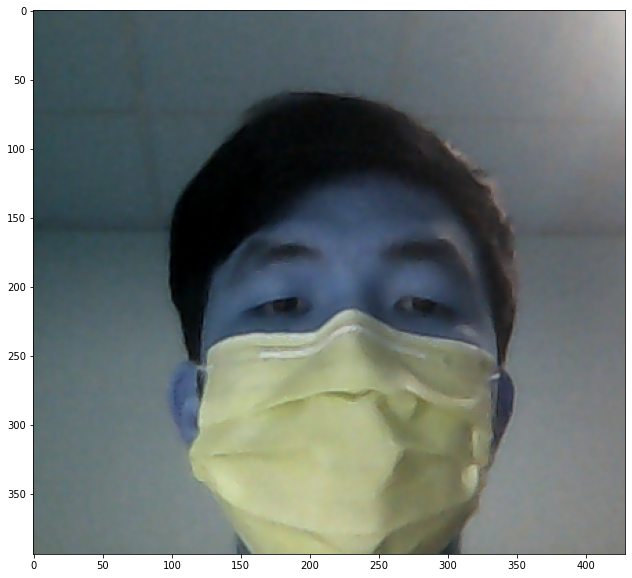

In [11]:
from scipy import misc

print('Start Recognition!')

face_input = "data/test/9.png"

find_results = []
frame = cv2.imread(face_input) # 讀入圖像
draw = frame.copy() # 複製原圖像

frame = frame[:,:,::-1] # 把BGR轉換成RGB
# 步驟 #1.偵測人臉位置
# 偵測人臉的邊界框
bounding_boxes, _ = detect_face.detect_face(frame, minsize, pnet, rnet, onet, threshold, factor)
nrof_faces = bounding_boxes.shape[0] # 被偵測到的臉部總數
if nrof_faces > 0: # 如果有偵測到人臉
    # 每一個 bounding_box包括了（x1,y1,x2,y2,confidence score)：
    # 　　左上角座標 (x1,y1)
    #     右下角座標 (x2,y2)
    #     信心分數 confidence score
    det = bounding_boxes[:, 0:4].astype(int) # 取出邊界框座標
    img_size = np.asarray(frame.shape)[0:2] # 原圖像大小 (height, width)
    
    print("Image: ", img_size)
    
    # 人臉圖像前處理的暫存
    cropped = []
    scaled = []
    scaled_reshape = []
    bb = np.zeros((nrof_faces,4), dtype=np.int32)
    
    # 步驟 #2.擷取人臉特徵
    for i in range(nrof_faces):
        print("faces#{}".format(i))
        emb_array = np.zeros((1, embedding_size))

        x1 = bb[i][0] = det[i][0]
        y1 = bb[i][1] = det[i][1]
        x2 = bb[i][2] = det[i][2]
        y2 = bb[i][3] = det[i][3]
        
        print('({}, {}) : ({}, {})'.format(x1,y1,x2,y2))
        # inner exception
        if bb[i][0] <= 0 or bb[i][1] <= 0 or bb[i][2] >= len(frame[0]) or bb[i][3] >= len(frame):
            print('face is out of range!')
            continue
        
        # **人臉圖像的前處理 **
            
        # 根據邊界框的座標來進行人臉的裁剪
        cropped.append(frame[bb[i][1]:bb[i][3], bb[i][0]:bb[i][2], :])
        cropped[i] = facenet.flip(cropped[i], False)
        scaled.append(misc.imresize(cropped[i], (image_size, image_size), interp='bilinear'))
        scaled[i] = cv2.resize(scaled[i], (input_image_size,input_image_size),
                               interpolation=cv2.INTER_CUBIC)
        scaled[i] = facenet.prewhiten(scaled[i])
        scaled_reshape.append(scaled[i].reshape(-1,input_image_size,input_image_size,3))       
        feed_dict = {images_placeholder: scaled_reshape[i], phase_train_placeholder: False}
        
        # 進行臉部特徵擷取
        emb_array[0, :] = tf_sess.run(embeddings, feed_dict=feed_dict)
        
        # 步驟 #3.進行人臉識別分類
        face_id_idx = face_svc_classifier.predict(emb_array)   
            
        if is_same_person(emb_array, int(face_id_idx), 1.1):            
            face_id_name = HumanNames[int(face_id_idx)] # 取出人臉的名字
            bb_color = vis_utils.STANDARD_COLORS[i] # 給予不同的顏色
            bb_fontcolor = 'black'
            
        else:
            face_id_name = 'Unknown'
            bb_color = 'BlueViolet' # 給予紅色
            bb_fontcolor = 'white'
            
        print("name: ",face_id_name)        
        # 進行視覺化的展現
        vis_utils.draw_bounding_box_on_image_array(draw,y1,x1,y2,x2,
                                                   color=bb_color,
                                                   thickness=2,
                                                   display_str_list=[face_id_name],
                                                   fontname='calibrib.ttf',         # <-- 替換不同的字型
                                                   fontsize=15,                     # <-- 根據圖像大小設定字型大小
                                                   fontcolor=bb_fontcolor,
                                                   use_normalized_coordinates=False)
else:
    print('Unable to align')

print('Detected_FaceNum: %d' % nrof_faces)

# 設定展示的大小
plt.figure(figsize=(20,10))

# 展示偵測出來的結果
plt.imshow(draw[:,:,::-1]) # 轉換成RGB來給matplotlib展示
plt.show()

misc.imsave('haha.png', draw[:,:,::-1])

從以上的結果來看, 我們辨識出5張人臉。其中"Barack Obama(歐巴馬)"並不在我們從lfw的人臉資料庫中選出423個人臉的類別裡頭。所以從驗證結果來看, 這個人臉的識別效果還不錯。

### 參考:
* Facenet-Github (davidsandberg/facenet) - https://github.com/davidsandberg/facenet
* OpenFace-Github (cmusatyalab/openface) - https://github.com/cmusatyalab/openface
* Multi-task Cascaded Convolutional Networks論文 - https://arxiv.org/abs/1604.02878
* FaceNet: A Unified Embedding for Face Recognition and Clustering論文 - https://arxiv.org/abs/1503.03832